# PreProcessing


**The following packages will be used to implement a basic GAN system in Python/Keras. Importing libraries and layers from tensorflow.**

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


**The following code mounts Google drive for use with Google CoLab**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


 **DATASET for cropped aloa lactinea insect- https://drive.google.com/file/d/1xS3R77DSzf443uuPWKEa7duSmwBykUes/view?usp=sharing This dataset has 999 cropped images of the aloa lactinea insect and is of 26 MB(uncompressed).Download the dataset and upload to colab directly or upload zipped version of the file and mount your drive and later unzip them for using.**



**Unzipping dataset to the below mentioned path directory in google drive.**

In [2]:
!unzip "/content/drive/My Drive/minor/cropped aloa lectinea.zip" #link of compressed dataset

Archive:  /content/drive/My Drive/minor/cropped aloa lectinea.zip
  inflating: cropped aloa lectinea/insect (1).jpg  
  inflating: cropped aloa lectinea/insect (10).jpg  
  inflating: cropped aloa lectinea/insect (100).jpg  
  inflating: cropped aloa lectinea/insect (101).jpg  
  inflating: cropped aloa lectinea/insect (102).jpg  
  inflating: cropped aloa lectinea/insect (103).jpg  
  inflating: cropped aloa lectinea/insect (104).jpg  
  inflating: cropped aloa lectinea/insect (105).jpg  
  inflating: cropped aloa lectinea/insect (106).jpg  
  inflating: cropped aloa lectinea/insect (107).jpg  
  inflating: cropped aloa lectinea/insect (108).jpg  
  inflating: cropped aloa lectinea/insect (109).jpg  
  inflating: cropped aloa lectinea/insect (11).jpg  
  inflating: cropped aloa lectinea/insect (110).jpg  
  inflating: cropped aloa lectinea/insect (111).jpg  
  inflating: cropped aloa lectinea/insect (112).jpg  
  inflating: cropped aloa lectinea/insect (113).jpg  
  inflating: cropped

**Setting hyperparameters for computation.Here, we mention parameters for image resolution, preview image size details,seed size,epochs,batch size and buffer size.**


In [3]:
#resolution of images
GENERATE_SQUARE = 96 #96x96
IMAGE_CHANNELS = 3  #RGB

# Preview images for viewing samples during training
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from (noise vector)
SEED_SIZE = 100  

# Configuration
DATA_PATH = '/content/cropped aloa lectinea' #copy file location of unzipped data
EPOCHS = 2000
BATCH_SIZE = 32
BUFFER_SIZE = 600

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


**We store the processed file as a binary. This way we can simply reload the processed training data and quickly use it. It is most efficient to only perform this operation once. The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change. Converting input images from the dataset to arrays. As the colored images have values of varying from (0,255) pixel values, scaling it to (-1, 1) as of generator's last layer's activation Tanh range.**

In [7]:
#converting of (255,255) pixel value to (-1, 1) as of generator's last layer's activation Tanh range

training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')


print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  print("Loading training images...")

  training_data = []
  faces_path = DATA_PATH
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)




  1%|          | 9/999 [00:00<00:13, 73.27it/s]

Looking for file: /content/cropped aloa lectinea/training_data_96_96.npy
Loading training images...



100%|██████████| 999/999 [00:09<00:00, 102.89it/s]


Saving training image binary...


**We will use a TensorFlow Dataset object to actually hold the images. This allows the data to be quickly shuffled int divided into the appropriate batch sizes for training.Making batches of dataset for training the model in batches.**

In [8]:
#making batches of data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# GAN

**Making a generator network using Sequential model to add the following layers.**

In [9]:
#generator network
generator = keras.models.Sequential([
    keras.layers.Dense(6*6*256, input_shape=[SEED_SIZE]),
    keras.layers.Reshape([6, 6, 256]),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same"),
    keras.layers.ReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, (5,5), (2,2), padding="same"),
    keras.layers.ReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, (5,5), (2,2), padding="same"),
    keras.layers.ReLU(),
    keras.layers.Conv2DTranspose(3, (5,5), (2,2), padding="same", activation="tanh"),
])

**Input, output dimensions and parameters of every layer of generator**

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9216)              930816    
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 64)        409664    
_________________________________________________________________
re_lu (ReLU)                 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 32)        51232     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 24, 24, 32)        0

**Making a discriminator network using Sequential model to add the following layers.**

In [11]:
#discriminator network
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), (2,2), padding="same", input_shape=[96, 96, 3]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

**Input,output dimensions and parameters of every layer of discriminator**

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        2432      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)       

# Saving images

**OUT_PATH gives the destination to store the images that our deep-convolutional gan network will generate.**

In [13]:
mkdir '/content/drive/My Drive/minor/final_aloa'

In [14]:
OUT_PATH='/content/drive/My Drive/minor/final_aloa'

**As we progress through training images will be produced to show the progress.These images will contain a number of rendered insects that show how good the generator has become.Below cell has a function to save coloured images generated by dcgan in 7x4 grid to preview the images.** 

In [15]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(OUT_PATH,f"output-{cnt}")
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)
  generator.save(os.path.join(output_path,f"face_generator-{cnt}.h5"))

# Testing networks

**Before training the model, generate random sample by adding noise in generator network and specifying training as false.**

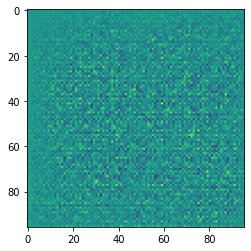

In [16]:
#generating random sample before training
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

**Checking discriminator's decision on the random sample generated.**

In [17]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4998739]], shape=(1, 1), dtype=float32)


# Compiling Gan

**For the generator training set, the $x$ contains the random seeds to generate images and the $y$ always contains the value of 1, because the optimal is for the generator to have generated such good images that the discriminiator was fooled into assigning them a probability near 1.Defining loss for generator and discriminator networks. Binary crossentropy loss has been used. For the generator network the loss is only determined by the fake output that it generates.For discriminator network,total loss is the sum of loss for real and fake outputs.**

In [18]:
#defining losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**In this cell optimizer for the generator and discriminator networks have been defined. Adam optimizer(with a learning rate of 1.5e-4) is used for both the networks.**

In [19]:
#defining otptimizer
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

# Training the Gan


**Defining a fuction for train the dcgan. We train the model by giving randomly generated seed values to the generator. The generator gives an output image, this image along with real image is feeded to the discriminator network. Gradients are calculated for both these network in the basis of generator loss and discriminator loss. Later, optimization is done using these gradients.**

In [20]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)#calculating gradients of generator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)#calculating gradients of discriminator

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))#applying gradients with the optimizer
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))#applying gradients with the optimizer
  return gen_loss,disc_loss

In [21]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))

  for epoch in tqdm(range(epochs)):


    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)


    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}')
    if epoch%100==0:
      save_images(epoch,fixed_seed)


  print (f'Training time: {hms_string(epoch_elapsed)}')

**Calling the train fuction to start train the gan model for desired number of epochs.**

In [22]:
train(train_dataset, EPOCHS)


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1, gen loss=0.6136048436164856,disc loss=1.150124430656433



  0%|          | 2/2000 [00:08<2:55:35,  5.27s/it]

Epoch 2, gen loss=0.6760309338569641,disc loss=1.0350135564804077



  0%|          | 3/2000 [00:10<2:23:44,  4.32s/it]

Epoch 3, gen loss=0.6852465867996216,disc loss=1.0207791328430176



  0%|          | 4/2000 [00:12<2:01:21,  3.65s/it]

Epoch 4, gen loss=0.6895169615745544,disc loss=1.0136432647705078



  0%|          | 5/2000 [00:15<1:45:50,  3.18s/it]

Epoch 5, gen loss=0.6907926797866821,disc loss=1.01139497756958



  0%|          | 6/2000 [00:17<1:34:50,  2.85s/it]

Epoch 6, gen loss=0.6918479204177856,disc loss=1.0093562602996826



  0%|          | 7/2000 [00:19<1:27:09,  2.62s/it]

Epoch 7, gen loss=0.6920564770698547,disc loss=1.0089313983917236



  0%|          | 8/2000 [00:21<1:21:46,  2.46s/it]

Epoch 8, gen loss=0.6925296783447266,disc loss=1.0079082250595093



  0%|          | 9/2000 [00:23<1:17:58,  2.35s/it]

Epoch 9, gen loss=0.6924771666526794,disc loss=1.007838487625122



  0%|          | 10/2000 [00:25<1:15:27,  2.28s/it]

Epoch 10, gen loss=0.6923859715461731,disc loss=1.007658839225769



  1%|          | 11/2000 [00:27<1:13:33,  2.22s/it]

Epoch 11, gen loss=0.6925653219223022,disc loss=1.0076930522918701



  1%|          | 12/2000 [00:29<1:12:08,  2.18s/it]

Epoch 12, gen loss=0.6927602291107178,disc loss=1.0073628425598145



  1%|          | 13/2000 [00:31<1:11:06,  2.15s/it]

Epoch 13, gen loss=0.6929221749305725,disc loss=1.0069197416305542



  1%|          | 14/2000 [00:33<1:10:20,  2.13s/it]

Epoch 14, gen loss=0.6929503679275513,disc loss=1.0069059133529663



  1%|          | 15/2000 [00:35<1:09:48,  2.11s/it]

Epoch 15, gen loss=0.6930544376373291,disc loss=1.0066674947738647



  1%|          | 16/2000 [00:37<1:09:36,  2.11s/it]

Epoch 16, gen loss=0.6930676102638245,disc loss=1.0066540241241455



  1%|          | 17/2000 [00:40<1:09:21,  2.10s/it]

Epoch 17, gen loss=0.6930795907974243,disc loss=1.0065953731536865



  1%|          | 18/2000 [00:42<1:09:05,  2.09s/it]

Epoch 18, gen loss=0.6930832266807556,disc loss=1.0065639019012451



  1%|          | 19/2000 [00:44<1:09:04,  2.09s/it]

Epoch 19, gen loss=0.6930932402610779,disc loss=1.0065293312072754



  1%|          | 20/2000 [00:46<1:08:59,  2.09s/it]

Epoch 20, gen loss=0.6930950880050659,disc loss=1.0065650939941406



  1%|          | 21/2000 [00:48<1:08:57,  2.09s/it]

Epoch 21, gen loss=0.6931077241897583,disc loss=1.0065062046051025



  1%|          | 22/2000 [00:50<1:08:52,  2.09s/it]

Epoch 22, gen loss=0.6931183338165283,disc loss=1.006492257118225



  1%|          | 23/2000 [00:52<1:08:45,  2.09s/it]

Epoch 23, gen loss=0.6931119561195374,disc loss=1.006498098373413



  1%|          | 24/2000 [00:54<1:08:35,  2.08s/it]

Epoch 24, gen loss=0.693130373954773,disc loss=1.0064795017242432



  1%|▏         | 25/2000 [00:56<1:08:24,  2.08s/it]

Epoch 25, gen loss=0.693122148513794,disc loss=1.006473422050476



  1%|▏         | 26/2000 [00:58<1:08:19,  2.08s/it]

Epoch 26, gen loss=0.6931287050247192,disc loss=1.0064642429351807



  1%|▏         | 27/2000 [01:00<1:08:17,  2.08s/it]

Epoch 27, gen loss=0.6931337714195251,disc loss=1.0064536333084106



  1%|▏         | 28/2000 [01:02<1:08:09,  2.07s/it]

Epoch 28, gen loss=0.6931307315826416,disc loss=1.0064462423324585



  1%|▏         | 29/2000 [01:04<1:08:19,  2.08s/it]

Epoch 29, gen loss=0.693135142326355,disc loss=1.0064409971237183



  2%|▏         | 30/2000 [01:07<1:08:20,  2.08s/it]

Epoch 30, gen loss=0.6931363940238953,disc loss=1.0064489841461182



  2%|▏         | 31/2000 [01:09<1:08:18,  2.08s/it]

Epoch 31, gen loss=0.6931366324424744,disc loss=1.0064367055892944



  2%|▏         | 32/2000 [01:11<1:08:15,  2.08s/it]

Epoch 32, gen loss=0.693135142326355,disc loss=1.0064457654953003



  2%|▏         | 33/2000 [01:13<1:08:06,  2.08s/it]

Epoch 33, gen loss=0.6931352615356445,disc loss=1.006447434425354



  2%|▏         | 34/2000 [01:15<1:07:58,  2.07s/it]

Epoch 34, gen loss=0.6931325197219849,disc loss=1.0064475536346436



  2%|▏         | 35/2000 [01:17<1:07:59,  2.08s/it]

Epoch 35, gen loss=0.6931374073028564,disc loss=1.006438136100769



  2%|▏         | 36/2000 [01:19<1:07:52,  2.07s/it]

Epoch 36, gen loss=0.6931407451629639,disc loss=1.0064282417297363



  2%|▏         | 37/2000 [01:21<1:07:55,  2.08s/it]

Epoch 37, gen loss=0.6931410431861877,disc loss=1.0064300298690796



  2%|▏         | 38/2000 [01:23<1:07:45,  2.07s/it]

Epoch 38, gen loss=0.6931381821632385,disc loss=1.0064388513565063



  2%|▏         | 39/2000 [01:25<1:07:41,  2.07s/it]

Epoch 39, gen loss=0.693139374256134,disc loss=1.0064358711242676



  2%|▏         | 40/2000 [01:27<1:07:43,  2.07s/it]

Epoch 40, gen loss=0.6931380033493042,disc loss=1.0064343214035034



  2%|▏         | 41/2000 [01:29<1:07:36,  2.07s/it]

Epoch 41, gen loss=0.6931406855583191,disc loss=1.0064276456832886



  2%|▏         | 42/2000 [01:31<1:07:34,  2.07s/it]

Epoch 42, gen loss=0.6931389570236206,disc loss=1.0064305067062378



  2%|▏         | 43/2000 [01:34<1:07:34,  2.07s/it]

Epoch 43, gen loss=0.6931414604187012,disc loss=1.0064257383346558



  2%|▏         | 44/2000 [01:36<1:07:38,  2.07s/it]

Epoch 44, gen loss=0.6931386590003967,disc loss=1.006439208984375



  2%|▏         | 45/2000 [01:38<1:07:36,  2.07s/it]

Epoch 45, gen loss=0.6931411027908325,disc loss=1.006426215171814



  2%|▏         | 46/2000 [01:40<1:07:31,  2.07s/it]

Epoch 46, gen loss=0.693141520023346,disc loss=1.0064257383346558



  2%|▏         | 47/2000 [01:42<1:07:29,  2.07s/it]

Epoch 47, gen loss=0.6931431293487549,disc loss=1.0064198970794678



  2%|▏         | 48/2000 [01:44<1:07:27,  2.07s/it]

Epoch 48, gen loss=0.6931427717208862,disc loss=1.0064241886138916



  2%|▏         | 49/2000 [01:46<1:07:30,  2.08s/it]

Epoch 49, gen loss=0.6931424736976624,disc loss=1.0064226388931274



  2%|▎         | 50/2000 [01:48<1:07:30,  2.08s/it]

Epoch 50, gen loss=0.6931434273719788,disc loss=1.0064183473587036



  3%|▎         | 51/2000 [01:50<1:07:23,  2.07s/it]

Epoch 51, gen loss=0.6931437849998474,disc loss=1.0064200162887573



  3%|▎         | 52/2000 [01:52<1:07:23,  2.08s/it]

Epoch 52, gen loss=0.693143904209137,disc loss=1.0064173936843872



  3%|▎         | 53/2000 [01:54<1:07:37,  2.08s/it]

Epoch 53, gen loss=0.6931439638137817,disc loss=1.0064176321029663



  3%|▎         | 54/2000 [01:56<1:07:31,  2.08s/it]

Epoch 54, gen loss=0.6931443810462952,disc loss=1.0064185857772827



  3%|▎         | 55/2000 [01:58<1:07:33,  2.08s/it]

Epoch 55, gen loss=0.693143904209137,disc loss=1.006416916847229



  3%|▎         | 56/2000 [02:01<1:07:22,  2.08s/it]

Epoch 56, gen loss=0.6931440830230713,disc loss=1.0064201354980469



  3%|▎         | 57/2000 [02:03<1:07:10,  2.07s/it]

Epoch 57, gen loss=0.6931435465812683,disc loss=1.0064197778701782



  3%|▎         | 58/2000 [02:05<1:07:09,  2.07s/it]

Epoch 58, gen loss=0.6931441426277161,disc loss=1.00641930103302



  3%|▎         | 59/2000 [02:07<1:07:00,  2.07s/it]

Epoch 59, gen loss=0.6931438446044922,disc loss=1.0064170360565186



  3%|▎         | 60/2000 [02:09<1:06:55,  2.07s/it]

Epoch 60, gen loss=0.6931448578834534,disc loss=1.0064165592193604



  3%|▎         | 61/2000 [02:11<1:07:02,  2.07s/it]

Epoch 61, gen loss=0.693143904209137,disc loss=1.0064159631729126



  3%|▎         | 62/2000 [02:13<1:06:59,  2.07s/it]

Epoch 62, gen loss=0.693143904209137,disc loss=1.0064197778701782



  3%|▎         | 63/2000 [02:15<1:06:56,  2.07s/it]

Epoch 63, gen loss=0.6931437253952026,disc loss=1.0064159631729126



  3%|▎         | 64/2000 [02:17<1:06:55,  2.07s/it]

Epoch 64, gen loss=0.6931449174880981,disc loss=1.0064146518707275



  3%|▎         | 65/2000 [02:19<1:06:51,  2.07s/it]

Epoch 65, gen loss=0.6931447386741638,disc loss=1.0064177513122559



  3%|▎         | 66/2000 [02:21<1:06:54,  2.08s/it]

Epoch 66, gen loss=0.6931445002555847,disc loss=1.006415843963623



  3%|▎         | 67/2000 [02:23<1:06:52,  2.08s/it]

Epoch 67, gen loss=0.6931442022323608,disc loss=1.0064163208007812



  3%|▎         | 68/2000 [02:25<1:06:51,  2.08s/it]

Epoch 68, gen loss=0.6931453347206116,disc loss=1.0064163208007812



  3%|▎         | 69/2000 [02:28<1:06:53,  2.08s/it]

Epoch 69, gen loss=0.6931445002555847,disc loss=1.0064165592193604



  4%|▎         | 70/2000 [02:30<1:06:47,  2.08s/it]

Epoch 70, gen loss=0.6931449174880981,disc loss=1.0064154863357544



  4%|▎         | 71/2000 [02:32<1:06:45,  2.08s/it]

Epoch 71, gen loss=0.6931449770927429,disc loss=1.0064175128936768



  4%|▎         | 72/2000 [02:34<1:06:38,  2.07s/it]

Epoch 72, gen loss=0.6931437253952026,disc loss=1.0064407587051392



  4%|▎         | 73/2000 [02:36<1:06:36,  2.07s/it]

Epoch 73, gen loss=0.6931381821632385,disc loss=1.006428599357605



  4%|▎         | 74/2000 [02:38<1:06:41,  2.08s/it]

Epoch 74, gen loss=0.6931437253952026,disc loss=1.006415843963623



  4%|▍         | 75/2000 [02:40<1:06:37,  2.08s/it]

Epoch 75, gen loss=0.6931445598602295,disc loss=1.0064163208007812



  4%|▍         | 76/2000 [02:42<1:06:31,  2.07s/it]

Epoch 76, gen loss=0.6931455731391907,disc loss=1.006415843963623



  4%|▍         | 77/2000 [02:44<1:06:27,  2.07s/it]

Epoch 77, gen loss=0.6931451559066772,disc loss=1.006414532661438



  4%|▍         | 78/2000 [02:46<1:06:25,  2.07s/it]

Epoch 78, gen loss=0.6931449174880981,disc loss=1.0064151287078857



  4%|▍         | 79/2000 [02:48<1:06:24,  2.07s/it]

Epoch 79, gen loss=0.6931453943252563,disc loss=1.0064138174057007



  4%|▍         | 80/2000 [02:50<1:06:24,  2.08s/it]

Epoch 80, gen loss=0.6931453943252563,disc loss=1.0064133405685425



  4%|▍         | 81/2000 [02:52<1:06:21,  2.08s/it]

Epoch 81, gen loss=0.6931453347206116,disc loss=1.0064144134521484



  4%|▍         | 82/2000 [02:54<1:06:23,  2.08s/it]

Epoch 82, gen loss=0.6931447982788086,disc loss=1.0064154863357544



  4%|▍         | 83/2000 [02:57<1:06:19,  2.08s/it]

Epoch 83, gen loss=0.6931448578834534,disc loss=1.0064153671264648



  4%|▍         | 84/2000 [02:59<1:06:17,  2.08s/it]

Epoch 84, gen loss=0.6931449174880981,disc loss=1.0064175128936768



  4%|▍         | 85/2000 [03:01<1:06:19,  2.08s/it]

Epoch 85, gen loss=0.6931446194648743,disc loss=1.0064139366149902



  4%|▍         | 86/2000 [03:03<1:06:15,  2.08s/it]

Epoch 86, gen loss=0.6931447982788086,disc loss=1.0064153671264648



  4%|▍         | 87/2000 [03:05<1:06:12,  2.08s/it]

Epoch 87, gen loss=0.6931451559066772,disc loss=1.0064138174057007



  4%|▍         | 88/2000 [03:07<1:06:13,  2.08s/it]

Epoch 88, gen loss=0.6931447386741638,disc loss=1.0064141750335693



  4%|▍         | 89/2000 [03:09<1:06:09,  2.08s/it]

Epoch 89, gen loss=0.693145751953125,disc loss=1.0064127445220947



  4%|▍         | 90/2000 [03:11<1:06:07,  2.08s/it]

Epoch 90, gen loss=0.6931455135345459,disc loss=1.0064141750335693



  5%|▍         | 91/2000 [03:13<1:06:02,  2.08s/it]

Epoch 91, gen loss=0.6931446194648743,disc loss=1.0064151287078857



  5%|▍         | 92/2000 [03:15<1:05:54,  2.07s/it]

Epoch 92, gen loss=0.693145215511322,disc loss=1.0064138174057007



  5%|▍         | 93/2000 [03:17<1:05:56,  2.07s/it]

Epoch 93, gen loss=0.6931450963020325,disc loss=1.0064144134521484



  5%|▍         | 94/2000 [03:19<1:05:49,  2.07s/it]

Epoch 94, gen loss=0.6931455135345459,disc loss=1.0064127445220947



  5%|▍         | 95/2000 [03:21<1:05:51,  2.07s/it]

Epoch 95, gen loss=0.6931459307670593,disc loss=1.006412386894226



  5%|▍         | 96/2000 [03:24<1:05:57,  2.08s/it]

Epoch 96, gen loss=0.6931455731391907,disc loss=1.0064151287078857



  5%|▍         | 97/2000 [03:26<1:05:46,  2.07s/it]

Epoch 97, gen loss=0.6931453347206116,disc loss=1.0064133405685425



  5%|▍         | 98/2000 [03:28<1:05:51,  2.08s/it]

Epoch 98, gen loss=0.6931451559066772,disc loss=1.0064141750335693



  5%|▍         | 99/2000 [03:30<1:05:48,  2.08s/it]

Epoch 99, gen loss=0.6931448578834534,disc loss=1.0064140558242798



  5%|▌         | 100/2000 [03:32<1:05:41,  2.07s/it]

Epoch 100, gen loss=0.6931461095809937,disc loss=1.006413221359253



  5%|▌         | 101/2000 [03:34<1:07:12,  2.12s/it]

Epoch 101, gen loss=0.6931440830230713,disc loss=1.0064170360565186



  5%|▌         | 102/2000 [03:36<1:06:40,  2.11s/it]

Epoch 102, gen loss=0.6931445002555847,disc loss=1.006415843963623



  5%|▌         | 103/2000 [03:38<1:06:17,  2.10s/it]

Epoch 103, gen loss=0.6931443214416504,disc loss=1.0064162015914917



  5%|▌         | 104/2000 [03:40<1:06:06,  2.09s/it]

Epoch 104, gen loss=0.693145215511322,disc loss=1.0064139366149902



  5%|▌         | 105/2000 [03:42<1:05:53,  2.09s/it]

Epoch 105, gen loss=0.693145215511322,disc loss=1.0064140558242798



  5%|▌         | 106/2000 [03:44<1:05:45,  2.08s/it]

Epoch 106, gen loss=0.6931454539299011,disc loss=1.006414532661438



  5%|▌         | 107/2000 [03:47<1:05:37,  2.08s/it]

Epoch 107, gen loss=0.6931450963020325,disc loss=1.0064150094985962



  5%|▌         | 108/2000 [03:49<1:05:28,  2.08s/it]

Epoch 108, gen loss=0.6931451559066772,disc loss=1.006413221359253



  5%|▌         | 109/2000 [03:51<1:05:26,  2.08s/it]

Epoch 109, gen loss=0.6931456327438354,disc loss=1.0064146518707275



  6%|▌         | 110/2000 [03:53<1:05:21,  2.07s/it]

Epoch 110, gen loss=0.6931448578834534,disc loss=1.0064153671264648



  6%|▌         | 111/2000 [03:55<1:05:23,  2.08s/it]

Epoch 111, gen loss=0.6931448578834534,disc loss=1.0064141750335693



  6%|▌         | 112/2000 [03:57<1:05:23,  2.08s/it]

Epoch 112, gen loss=0.6931443810462952,disc loss=1.006415843963623



  6%|▌         | 113/2000 [03:59<1:05:15,  2.07s/it]

Epoch 113, gen loss=0.6931455731391907,disc loss=1.0064135789871216



  6%|▌         | 114/2000 [04:01<1:05:11,  2.07s/it]

Epoch 114, gen loss=0.6931439638137817,disc loss=1.0064181089401245



  6%|▌         | 115/2000 [04:03<1:05:12,  2.08s/it]

Epoch 115, gen loss=0.6931453347206116,disc loss=1.0064140558242798



  6%|▌         | 116/2000 [04:05<1:05:10,  2.08s/it]

Epoch 116, gen loss=0.6931456327438354,disc loss=1.0064136981964111



  6%|▌         | 117/2000 [04:07<1:05:12,  2.08s/it]

Epoch 117, gen loss=0.6931452751159668,disc loss=1.0064139366149902



  6%|▌         | 118/2000 [04:09<1:05:12,  2.08s/it]

Epoch 118, gen loss=0.6931452751159668,disc loss=1.006414532661438



  6%|▌         | 119/2000 [04:11<1:05:15,  2.08s/it]

Epoch 119, gen loss=0.6931449174880981,disc loss=1.006414771080017



  6%|▌         | 120/2000 [04:14<1:05:11,  2.08s/it]

Epoch 120, gen loss=0.6931442022323608,disc loss=1.006415605545044



  6%|▌         | 121/2000 [04:16<1:05:04,  2.08s/it]

Epoch 121, gen loss=0.6931452751159668,disc loss=1.0064151287078857



  6%|▌         | 122/2000 [04:18<1:05:03,  2.08s/it]

Epoch 122, gen loss=0.6931443810462952,disc loss=1.0064154863357544



  6%|▌         | 123/2000 [04:20<1:04:56,  2.08s/it]

Epoch 123, gen loss=0.6931455731391907,disc loss=1.0064142942428589



  6%|▌         | 124/2000 [04:22<1:04:49,  2.07s/it]

Epoch 124, gen loss=0.693140983581543,disc loss=1.0064247846603394



  6%|▋         | 125/2000 [04:24<1:04:55,  2.08s/it]

Epoch 125, gen loss=0.6381694674491882,disc loss=1.2497353553771973



  6%|▋         | 126/2000 [04:26<1:04:49,  2.08s/it]

Epoch 126, gen loss=0.6864253878593445,disc loss=1.0699816942214966



  6%|▋         | 127/2000 [04:28<1:04:40,  2.07s/it]

Epoch 127, gen loss=0.6929664611816406,disc loss=1.0070314407348633



  6%|▋         | 128/2000 [04:30<1:04:41,  2.07s/it]

Epoch 128, gen loss=0.6882821321487427,disc loss=1.014802098274231



  6%|▋         | 129/2000 [04:32<1:04:43,  2.08s/it]

Epoch 129, gen loss=0.6929577589035034,disc loss=1.0094095468521118



  6%|▋         | 130/2000 [04:34<1:04:37,  2.07s/it]

Epoch 130, gen loss=0.6931368708610535,disc loss=1.00648033618927



  7%|▋         | 131/2000 [04:36<1:04:36,  2.07s/it]

Epoch 131, gen loss=0.6931379437446594,disc loss=1.0064632892608643



  7%|▋         | 132/2000 [04:38<1:04:31,  2.07s/it]

Epoch 132, gen loss=0.6930505633354187,disc loss=1.0065760612487793



  7%|▋         | 133/2000 [04:40<1:04:33,  2.07s/it]

Epoch 133, gen loss=0.6931467652320862,disc loss=1.0064278841018677



  7%|▋         | 134/2000 [04:43<1:04:28,  2.07s/it]

Epoch 134, gen loss=0.693132758140564,disc loss=1.0064697265625



  7%|▋         | 135/2000 [04:45<1:04:29,  2.08s/it]

Epoch 135, gen loss=0.6931450366973877,disc loss=1.0064232349395752



  7%|▋         | 136/2000 [04:47<1:04:32,  2.08s/it]

Epoch 136, gen loss=0.6931465268135071,disc loss=1.006424069404602



  7%|▋         | 137/2000 [04:49<1:04:29,  2.08s/it]

Epoch 137, gen loss=0.6931132674217224,disc loss=1.006460428237915



  7%|▋         | 138/2000 [04:51<1:04:27,  2.08s/it]

Epoch 138, gen loss=0.693146824836731,disc loss=1.006436824798584



  7%|▋         | 139/2000 [04:53<1:04:21,  2.07s/it]

Epoch 139, gen loss=0.6931471228599548,disc loss=1.0064170360565186



  7%|▋         | 140/2000 [04:55<1:04:16,  2.07s/it]

Epoch 140, gen loss=0.693146288394928,disc loss=1.006417989730835



  7%|▋         | 141/2000 [04:57<1:04:13,  2.07s/it]

Epoch 141, gen loss=0.6931468844413757,disc loss=1.0064406394958496



  7%|▋         | 142/2000 [04:59<1:04:12,  2.07s/it]

Epoch 142, gen loss=0.6931445598602295,disc loss=1.0064142942428589



  7%|▋         | 143/2000 [05:01<1:04:08,  2.07s/it]

Epoch 143, gen loss=0.693143904209137,disc loss=1.0064142942428589



  7%|▋         | 144/2000 [05:03<1:04:05,  2.07s/it]

Epoch 144, gen loss=0.6931430697441101,disc loss=1.0064191818237305



  7%|▋         | 145/2000 [05:05<1:04:07,  2.07s/it]

Epoch 145, gen loss=0.6931462287902832,disc loss=1.0064125061035156



  7%|▋         | 146/2000 [05:07<1:03:59,  2.07s/it]

Epoch 146, gen loss=0.6931440234184265,disc loss=1.00641667842865



  7%|▋         | 147/2000 [05:10<1:04:01,  2.07s/it]

Epoch 147, gen loss=0.6931462287902832,disc loss=1.0064114332199097



  7%|▋         | 148/2000 [05:12<1:03:58,  2.07s/it]

Epoch 148, gen loss=0.6931458711624146,disc loss=1.0064138174057007



  7%|▋         | 149/2000 [05:14<1:03:51,  2.07s/it]

Epoch 149, gen loss=0.6931461691856384,disc loss=1.0064128637313843



  8%|▊         | 150/2000 [05:16<1:03:48,  2.07s/it]

Epoch 150, gen loss=0.6931441426277161,disc loss=1.0064151287078857



  8%|▊         | 151/2000 [05:18<1:03:46,  2.07s/it]

Epoch 151, gen loss=0.6931453347206116,disc loss=1.0064148902893066



  8%|▊         | 152/2000 [05:20<1:03:43,  2.07s/it]

Epoch 152, gen loss=0.6931413412094116,disc loss=1.0064185857772827



  8%|▊         | 153/2000 [05:22<1:03:51,  2.07s/it]

Epoch 153, gen loss=0.6931455731391907,disc loss=1.0064140558242798



  8%|▊         | 154/2000 [05:24<1:03:49,  2.07s/it]

Epoch 154, gen loss=0.6931462287902832,disc loss=1.0064117908477783



  8%|▊         | 155/2000 [05:26<1:03:50,  2.08s/it]

Epoch 155, gen loss=0.693145751953125,disc loss=1.0064127445220947



  8%|▊         | 156/2000 [05:28<1:03:52,  2.08s/it]

Epoch 156, gen loss=0.6931442022323608,disc loss=1.006415605545044



  8%|▊         | 157/2000 [05:30<1:03:50,  2.08s/it]

Epoch 157, gen loss=0.6931458711624146,disc loss=1.0064133405685425



  8%|▊         | 158/2000 [05:32<1:03:47,  2.08s/it]

Epoch 158, gen loss=0.6931249499320984,disc loss=1.0064359903335571



  8%|▊         | 159/2000 [05:34<1:03:46,  2.08s/it]

Epoch 159, gen loss=0.6931463479995728,disc loss=1.006415605545044



  8%|▊         | 160/2000 [05:36<1:03:36,  2.07s/it]

Epoch 160, gen loss=0.693094789981842,disc loss=1.0064789056777954



  8%|▊         | 161/2000 [05:39<1:03:30,  2.07s/it]

Epoch 161, gen loss=0.6931324005126953,disc loss=1.0065007209777832



  8%|▊         | 162/2000 [05:41<1:03:25,  2.07s/it]

Epoch 162, gen loss=0.6931374073028564,disc loss=1.0064213275909424



  8%|▊         | 163/2000 [05:43<1:03:22,  2.07s/it]

Epoch 163, gen loss=0.6931440830230713,disc loss=1.0067640542984009



  8%|▊         | 164/2000 [05:45<1:03:22,  2.07s/it]

Epoch 164, gen loss=0.6835461854934692,disc loss=1.3034707307815552



  8%|▊         | 165/2000 [05:47<1:03:19,  2.07s/it]

Epoch 165, gen loss=0.6437087655067444,disc loss=1.270546793937683



  8%|▊         | 166/2000 [05:49<1:03:18,  2.07s/it]

Epoch 166, gen loss=0.6265155673027039,disc loss=1.2470206022262573



  8%|▊         | 167/2000 [05:51<1:03:19,  2.07s/it]

Epoch 167, gen loss=0.6722666025161743,disc loss=1.3141353130340576



  8%|▊         | 168/2000 [05:53<1:03:16,  2.07s/it]

Epoch 168, gen loss=0.651753306388855,disc loss=1.1773744821548462



  8%|▊         | 169/2000 [05:55<1:03:15,  2.07s/it]

Epoch 169, gen loss=0.6538509130477905,disc loss=1.192582607269287



  8%|▊         | 170/2000 [05:57<1:03:18,  2.08s/it]

Epoch 170, gen loss=0.651783287525177,disc loss=1.1574006080627441



  9%|▊         | 171/2000 [05:59<1:03:15,  2.08s/it]

Epoch 171, gen loss=0.6559047698974609,disc loss=1.14393150806427



  9%|▊         | 172/2000 [06:01<1:03:12,  2.07s/it]

Epoch 172, gen loss=0.6624962687492371,disc loss=1.1241871118545532



  9%|▊         | 173/2000 [06:03<1:03:17,  2.08s/it]

Epoch 173, gen loss=0.6665627956390381,disc loss=1.1086523532867432



  9%|▊         | 174/2000 [06:06<1:03:09,  2.08s/it]

Epoch 174, gen loss=0.6610413193702698,disc loss=1.1316014528274536



  9%|▉         | 175/2000 [06:08<1:03:08,  2.08s/it]

Epoch 175, gen loss=0.6601118445396423,disc loss=1.116798758506775



  9%|▉         | 176/2000 [06:10<1:03:02,  2.07s/it]

Epoch 176, gen loss=0.667415976524353,disc loss=1.092840552330017



  9%|▉         | 177/2000 [06:12<1:03:01,  2.07s/it]

Epoch 177, gen loss=0.6669020652770996,disc loss=1.0890270471572876



  9%|▉         | 178/2000 [06:14<1:02:58,  2.07s/it]

Epoch 178, gen loss=0.6681038737297058,disc loss=1.0901621580123901



  9%|▉         | 179/2000 [06:16<1:02:52,  2.07s/it]

Epoch 179, gen loss=0.6648942828178406,disc loss=1.101475715637207



  9%|▉         | 180/2000 [06:18<1:03:03,  2.08s/it]

Epoch 180, gen loss=0.6627672910690308,disc loss=1.1052864789962769



  9%|▉         | 181/2000 [06:20<1:03:01,  2.08s/it]

Epoch 181, gen loss=0.6701839566230774,disc loss=1.085261344909668



  9%|▉         | 182/2000 [06:22<1:03:06,  2.08s/it]

Epoch 182, gen loss=0.6615530848503113,disc loss=1.1104739904403687



  9%|▉         | 183/2000 [06:24<1:03:03,  2.08s/it]

Epoch 183, gen loss=0.6636582016944885,disc loss=1.0901964902877808



  9%|▉         | 184/2000 [06:26<1:02:56,  2.08s/it]

Epoch 184, gen loss=0.6717871427536011,disc loss=1.0665454864501953



  9%|▉         | 185/2000 [06:28<1:02:53,  2.08s/it]

Epoch 185, gen loss=0.6767203211784363,disc loss=1.0548874139785767



  9%|▉         | 186/2000 [06:30<1:02:48,  2.08s/it]

Epoch 186, gen loss=0.675484836101532,disc loss=1.059720754623413



  9%|▉         | 187/2000 [06:33<1:02:49,  2.08s/it]

Epoch 187, gen loss=0.6682445406913757,disc loss=1.141940712928772



  9%|▉         | 188/2000 [06:35<1:02:46,  2.08s/it]

Epoch 188, gen loss=0.6732487678527832,disc loss=1.0776382684707642



  9%|▉         | 189/2000 [06:37<1:02:43,  2.08s/it]

Epoch 189, gen loss=0.6651216745376587,disc loss=1.0862340927124023



 10%|▉         | 190/2000 [06:39<1:02:43,  2.08s/it]

Epoch 190, gen loss=0.6682127714157104,disc loss=1.0987491607666016



 10%|▉         | 191/2000 [06:41<1:02:45,  2.08s/it]

Epoch 191, gen loss=0.6745209097862244,disc loss=1.0648233890533447



 10%|▉         | 192/2000 [06:43<1:02:39,  2.08s/it]

Epoch 192, gen loss=0.6763554215431213,disc loss=1.0573192834854126



 10%|▉         | 193/2000 [06:45<1:02:36,  2.08s/it]

Epoch 193, gen loss=0.6733961701393127,disc loss=1.0692307949066162



 10%|▉         | 194/2000 [06:47<1:02:31,  2.08s/it]

Epoch 194, gen loss=0.6615701913833618,disc loss=1.1011345386505127



 10%|▉         | 195/2000 [06:49<1:02:28,  2.08s/it]

Epoch 195, gen loss=0.6646909713745117,disc loss=1.0885846614837646



 10%|▉         | 196/2000 [06:51<1:02:24,  2.08s/it]

Epoch 196, gen loss=0.6645904183387756,disc loss=1.0938419103622437



 10%|▉         | 197/2000 [06:53<1:02:24,  2.08s/it]

Epoch 197, gen loss=0.6586965322494507,disc loss=1.098379135131836



 10%|▉         | 198/2000 [06:55<1:02:21,  2.08s/it]

Epoch 198, gen loss=0.6643518805503845,disc loss=1.102455973625183



 10%|▉         | 199/2000 [06:57<1:02:15,  2.07s/it]

Epoch 199, gen loss=0.663192868232727,disc loss=1.0932540893554688



 10%|█         | 200/2000 [07:00<1:02:22,  2.08s/it]

Epoch 200, gen loss=0.665212094783783,disc loss=1.098214864730835



 10%|█         | 201/2000 [07:02<1:04:02,  2.14s/it]

Epoch 201, gen loss=0.6647886633872986,disc loss=1.0903359651565552



 10%|█         | 202/2000 [07:04<1:03:28,  2.12s/it]

Epoch 202, gen loss=0.6658179759979248,disc loss=1.0900511741638184



 10%|█         | 203/2000 [07:06<1:03:05,  2.11s/it]

Epoch 203, gen loss=0.6693013906478882,disc loss=1.0743714570999146



 10%|█         | 204/2000 [07:08<1:02:48,  2.10s/it]

Epoch 204, gen loss=0.6704856157302856,disc loss=1.0780994892120361



 10%|█         | 205/2000 [07:10<1:02:33,  2.09s/it]

Epoch 205, gen loss=0.6666197180747986,disc loss=1.08515202999115



 10%|█         | 206/2000 [07:12<1:02:22,  2.09s/it]

Epoch 206, gen loss=0.6769318580627441,disc loss=1.0549356937408447



 10%|█         | 207/2000 [07:14<1:02:15,  2.08s/it]

Epoch 207, gen loss=0.6657360196113586,disc loss=1.0858045816421509



 10%|█         | 208/2000 [07:16<1:02:09,  2.08s/it]

Epoch 208, gen loss=0.6693834662437439,disc loss=1.07974374294281



 10%|█         | 209/2000 [07:18<1:02:03,  2.08s/it]

Epoch 209, gen loss=0.6737017035484314,disc loss=1.0609593391418457



 10%|█         | 210/2000 [07:21<1:02:00,  2.08s/it]

Epoch 210, gen loss=0.6707800030708313,disc loss=1.0654528141021729



 11%|█         | 211/2000 [07:23<1:01:55,  2.08s/it]

Epoch 211, gen loss=0.6701789498329163,disc loss=1.0713380575180054



 11%|█         | 212/2000 [07:25<1:01:47,  2.07s/it]

Epoch 212, gen loss=0.673389196395874,disc loss=1.0625382661819458



 11%|█         | 213/2000 [07:27<1:01:48,  2.08s/it]

Epoch 213, gen loss=0.6761685609817505,disc loss=1.0542596578598022



 11%|█         | 214/2000 [07:29<1:01:49,  2.08s/it]

Epoch 214, gen loss=0.6767662167549133,disc loss=1.0587570667266846



 11%|█         | 215/2000 [07:31<1:01:51,  2.08s/it]

Epoch 215, gen loss=0.6779531240463257,disc loss=1.047624945640564



 11%|█         | 216/2000 [07:33<1:01:52,  2.08s/it]

Epoch 216, gen loss=0.6811364889144897,disc loss=1.042445182800293



 11%|█         | 217/2000 [07:35<1:01:49,  2.08s/it]

Epoch 217, gen loss=0.679129958152771,disc loss=1.0518146753311157



 11%|█         | 218/2000 [07:37<1:01:50,  2.08s/it]

Epoch 218, gen loss=0.6754227876663208,disc loss=1.0558457374572754



 11%|█         | 219/2000 [07:39<1:01:42,  2.08s/it]

Epoch 219, gen loss=0.6718185544013977,disc loss=1.0761692523956299



 11%|█         | 220/2000 [07:41<1:01:41,  2.08s/it]

Epoch 220, gen loss=0.6778937578201294,disc loss=1.0540735721588135



 11%|█         | 221/2000 [07:43<1:01:43,  2.08s/it]

Epoch 221, gen loss=0.6743295788764954,disc loss=1.0622843503952026



 11%|█         | 222/2000 [07:45<1:01:37,  2.08s/it]

Epoch 222, gen loss=0.6701653003692627,disc loss=1.0732316970825195



 11%|█         | 223/2000 [07:48<1:01:33,  2.08s/it]

Epoch 223, gen loss=0.6711201071739197,disc loss=1.1190904378890991



 11%|█         | 224/2000 [07:50<1:01:26,  2.08s/it]

Epoch 224, gen loss=0.6749088764190674,disc loss=1.0612318515777588



 11%|█▏        | 225/2000 [07:52<1:01:22,  2.07s/it]

Epoch 225, gen loss=0.6696241497993469,disc loss=1.0708210468292236



 11%|█▏        | 226/2000 [07:54<1:01:23,  2.08s/it]

Epoch 226, gen loss=0.6765010356903076,disc loss=1.0568656921386719



 11%|█▏        | 227/2000 [07:56<1:01:18,  2.07s/it]

Epoch 227, gen loss=0.67280513048172,disc loss=1.065792441368103



 11%|█▏        | 228/2000 [07:58<1:01:20,  2.08s/it]

Epoch 228, gen loss=0.6720653176307678,disc loss=1.0716630220413208



 11%|█▏        | 229/2000 [08:00<1:01:18,  2.08s/it]

Epoch 229, gen loss=0.674932599067688,disc loss=1.0536855459213257



 12%|█▏        | 230/2000 [08:02<1:01:14,  2.08s/it]

Epoch 230, gen loss=0.6753259897232056,disc loss=1.0533372163772583



 12%|█▏        | 231/2000 [08:04<1:01:16,  2.08s/it]

Epoch 231, gen loss=0.6750695705413818,disc loss=1.0567024946212769



 12%|█▏        | 232/2000 [08:06<1:01:15,  2.08s/it]

Epoch 232, gen loss=0.6785111427307129,disc loss=1.0490736961364746



 12%|█▏        | 233/2000 [08:08<1:01:07,  2.08s/it]

Epoch 233, gen loss=0.6773548126220703,disc loss=1.0479754209518433



 12%|█▏        | 234/2000 [08:10<1:01:02,  2.07s/it]

Epoch 234, gen loss=0.6750487089157104,disc loss=1.0554252862930298



 12%|█▏        | 235/2000 [08:12<1:00:48,  2.07s/it]

Epoch 235, gen loss=0.6792871356010437,disc loss=1.0555920600891113



 12%|█▏        | 236/2000 [08:14<1:00:44,  2.07s/it]

Epoch 236, gen loss=0.6777656078338623,disc loss=1.0543289184570312



 12%|█▏        | 237/2000 [08:17<1:00:43,  2.07s/it]

Epoch 237, gen loss=0.6756201386451721,disc loss=1.0566256046295166



 12%|█▏        | 238/2000 [08:19<1:00:37,  2.06s/it]

Epoch 238, gen loss=0.671672523021698,disc loss=1.0672903060913086



 12%|█▏        | 239/2000 [08:21<1:00:39,  2.07s/it]

Epoch 239, gen loss=0.6734796762466431,disc loss=1.0576566457748413



 12%|█▏        | 240/2000 [08:23<1:00:38,  2.07s/it]

Epoch 240, gen loss=0.6750718355178833,disc loss=1.058847427368164



 12%|█▏        | 241/2000 [08:25<1:00:34,  2.07s/it]

Epoch 241, gen loss=0.6788381934165955,disc loss=1.049792766571045



 12%|█▏        | 242/2000 [08:27<1:00:28,  2.06s/it]

Epoch 242, gen loss=0.6787636280059814,disc loss=1.052484154701233



 12%|█▏        | 243/2000 [08:29<1:00:29,  2.07s/it]

Epoch 243, gen loss=0.671705424785614,disc loss=1.0679547786712646



 12%|█▏        | 244/2000 [08:31<1:00:25,  2.06s/it]

Epoch 244, gen loss=0.6730203032493591,disc loss=1.0631132125854492



 12%|█▏        | 245/2000 [08:33<1:00:23,  2.06s/it]

Epoch 245, gen loss=0.6728017330169678,disc loss=1.0627716779708862



 12%|█▏        | 246/2000 [08:35<1:00:19,  2.06s/it]

Epoch 246, gen loss=0.6741084456443787,disc loss=1.0615075826644897



 12%|█▏        | 247/2000 [08:37<1:00:16,  2.06s/it]

Epoch 247, gen loss=0.6767922639846802,disc loss=1.0592652559280396



 12%|█▏        | 248/2000 [08:39<1:00:16,  2.06s/it]

Epoch 248, gen loss=0.6756128668785095,disc loss=1.0592354536056519



 12%|█▏        | 249/2000 [08:41<1:00:09,  2.06s/it]

Epoch 249, gen loss=0.6764672994613647,disc loss=1.0534354448318481



 12%|█▎        | 250/2000 [08:43<1:00:07,  2.06s/it]

Epoch 250, gen loss=0.6805739402770996,disc loss=1.0469818115234375



 13%|█▎        | 251/2000 [08:45<1:00:03,  2.06s/it]

Epoch 251, gen loss=0.6807551980018616,disc loss=1.0417441129684448



 13%|█▎        | 252/2000 [08:47<59:58,  2.06s/it]  

Epoch 252, gen loss=0.6791552305221558,disc loss=1.0475666522979736



 13%|█▎        | 253/2000 [08:50<59:55,  2.06s/it]

Epoch 253, gen loss=0.6755071878433228,disc loss=1.060367465019226



 13%|█▎        | 254/2000 [08:52<59:52,  2.06s/it]

Epoch 254, gen loss=0.6773195266723633,disc loss=1.0474213361740112



 13%|█▎        | 255/2000 [08:54<59:50,  2.06s/it]

Epoch 255, gen loss=0.677230954170227,disc loss=1.0500363111495972



 13%|█▎        | 256/2000 [08:56<59:48,  2.06s/it]

Epoch 256, gen loss=0.6758034229278564,disc loss=1.0606091022491455



 13%|█▎        | 257/2000 [08:58<59:50,  2.06s/it]

Epoch 257, gen loss=0.679229199886322,disc loss=1.0436257123947144



 13%|█▎        | 258/2000 [09:00<59:53,  2.06s/it]

Epoch 258, gen loss=0.6772950291633606,disc loss=1.0495429039001465



 13%|█▎        | 259/2000 [09:02<59:48,  2.06s/it]

Epoch 259, gen loss=0.6722679734230042,disc loss=1.0693196058273315



 13%|█▎        | 260/2000 [09:04<59:49,  2.06s/it]

Epoch 260, gen loss=0.6771252155303955,disc loss=1.053756594657898



 13%|█▎        | 261/2000 [09:06<59:50,  2.06s/it]

Epoch 261, gen loss=0.6748960614204407,disc loss=1.0611032247543335



 13%|█▎        | 262/2000 [09:08<59:48,  2.06s/it]

Epoch 262, gen loss=0.6771575212478638,disc loss=1.0518559217453003



 13%|█▎        | 263/2000 [09:10<59:42,  2.06s/it]

Epoch 263, gen loss=0.6764194369316101,disc loss=1.0562481880187988



 13%|█▎        | 264/2000 [09:12<59:44,  2.06s/it]

Epoch 264, gen loss=0.682808518409729,disc loss=1.0364052057266235



 13%|█▎        | 265/2000 [09:14<59:40,  2.06s/it]

Epoch 265, gen loss=0.6796815991401672,disc loss=1.0469425916671753



 13%|█▎        | 266/2000 [09:16<59:37,  2.06s/it]

Epoch 266, gen loss=0.6744112968444824,disc loss=1.0545852184295654



 13%|█▎        | 267/2000 [09:18<59:34,  2.06s/it]

Epoch 267, gen loss=0.6799514293670654,disc loss=1.0441274642944336



 13%|█▎        | 268/2000 [09:20<59:37,  2.07s/it]

Epoch 268, gen loss=0.6756392121315002,disc loss=1.0572360754013062



 13%|█▎        | 269/2000 [09:23<59:32,  2.06s/it]

Epoch 269, gen loss=0.6773840188980103,disc loss=1.0527759790420532



 14%|█▎        | 270/2000 [09:25<59:28,  2.06s/it]

Epoch 270, gen loss=0.6791775226593018,disc loss=1.0487618446350098



 14%|█▎        | 271/2000 [09:27<59:22,  2.06s/it]

Epoch 271, gen loss=0.6757892370223999,disc loss=1.057319164276123



 14%|█▎        | 272/2000 [09:29<59:15,  2.06s/it]

Epoch 272, gen loss=0.6784173250198364,disc loss=1.045319676399231



 14%|█▎        | 273/2000 [09:31<59:12,  2.06s/it]

Epoch 273, gen loss=0.6762149930000305,disc loss=1.056350827217102



 14%|█▎        | 274/2000 [09:33<59:11,  2.06s/it]

Epoch 274, gen loss=0.676629364490509,disc loss=1.0619893074035645



 14%|█▍        | 275/2000 [09:35<59:11,  2.06s/it]

Epoch 275, gen loss=0.6821491122245789,disc loss=1.0409390926361084



 14%|█▍        | 276/2000 [09:37<59:06,  2.06s/it]

Epoch 276, gen loss=0.675824761390686,disc loss=1.0543608665466309



 14%|█▍        | 277/2000 [09:39<59:05,  2.06s/it]

Epoch 277, gen loss=0.6777321100234985,disc loss=1.0552690029144287



 14%|█▍        | 278/2000 [09:41<58:59,  2.06s/it]

Epoch 278, gen loss=0.6798884868621826,disc loss=1.046470284461975



 14%|█▍        | 279/2000 [09:43<59:01,  2.06s/it]

Epoch 279, gen loss=0.6800981163978577,disc loss=1.0501266717910767



 14%|█▍        | 280/2000 [09:45<58:54,  2.06s/it]

Epoch 280, gen loss=0.6786812543869019,disc loss=1.04693603515625



 14%|█▍        | 281/2000 [09:47<58:55,  2.06s/it]

Epoch 281, gen loss=0.6774693727493286,disc loss=1.05003023147583



 14%|█▍        | 282/2000 [09:49<58:58,  2.06s/it]

Epoch 282, gen loss=0.6794909834861755,disc loss=1.0442090034484863



 14%|█▍        | 283/2000 [09:51<58:58,  2.06s/it]

Epoch 283, gen loss=0.6829233169555664,disc loss=1.0352380275726318



 14%|█▍        | 284/2000 [09:53<58:55,  2.06s/it]

Epoch 284, gen loss=0.6800103187561035,disc loss=1.0444962978363037



 14%|█▍        | 285/2000 [09:55<58:55,  2.06s/it]

Epoch 285, gen loss=0.6811570525169373,disc loss=1.0414855480194092



 14%|█▍        | 286/2000 [09:58<58:55,  2.06s/it]

Epoch 286, gen loss=0.6787064075469971,disc loss=1.0628316402435303



 14%|█▍        | 287/2000 [10:00<58:50,  2.06s/it]

Epoch 287, gen loss=0.6768127679824829,disc loss=1.0525459051132202



 14%|█▍        | 288/2000 [10:02<58:43,  2.06s/it]

Epoch 288, gen loss=0.6768419742584229,disc loss=1.0497162342071533



 14%|█▍        | 289/2000 [10:04<58:45,  2.06s/it]

Epoch 289, gen loss=0.6802119016647339,disc loss=1.0440330505371094



 14%|█▍        | 290/2000 [10:06<58:39,  2.06s/it]

Epoch 290, gen loss=0.669299304485321,disc loss=1.0722863674163818



 15%|█▍        | 291/2000 [10:08<58:32,  2.06s/it]

Epoch 291, gen loss=0.6772454977035522,disc loss=1.0513625144958496



 15%|█▍        | 292/2000 [10:10<58:28,  2.05s/it]

Epoch 292, gen loss=0.6822219491004944,disc loss=1.0380460023880005



 15%|█▍        | 293/2000 [10:12<58:27,  2.05s/it]

Epoch 293, gen loss=0.6793555021286011,disc loss=1.0466936826705933



 15%|█▍        | 294/2000 [10:14<58:25,  2.05s/it]

Epoch 294, gen loss=0.6816110014915466,disc loss=1.0427299737930298



 15%|█▍        | 295/2000 [10:16<58:25,  2.06s/it]

Epoch 295, gen loss=0.6781372427940369,disc loss=1.0497517585754395



 15%|█▍        | 296/2000 [10:18<58:32,  2.06s/it]

Epoch 296, gen loss=0.6785649657249451,disc loss=1.049730896949768



 15%|█▍        | 297/2000 [10:20<58:26,  2.06s/it]

Epoch 297, gen loss=0.6787809729576111,disc loss=1.0488085746765137



 15%|█▍        | 298/2000 [10:22<58:19,  2.06s/it]

Epoch 298, gen loss=0.6813157796859741,disc loss=1.0384159088134766



 15%|█▍        | 299/2000 [10:24<58:16,  2.06s/it]

Epoch 299, gen loss=0.681291401386261,disc loss=1.0489352941513062



 15%|█▌        | 300/2000 [10:26<58:15,  2.06s/it]

Epoch 300, gen loss=0.6789188981056213,disc loss=1.0502126216888428



 15%|█▌        | 301/2000 [10:29<59:49,  2.11s/it]

Epoch 301, gen loss=0.6808493137359619,disc loss=1.037305474281311



 15%|█▌        | 302/2000 [10:31<59:22,  2.10s/it]

Epoch 302, gen loss=0.6783530712127686,disc loss=1.045426845550537



 15%|█▌        | 303/2000 [10:33<58:59,  2.09s/it]

Epoch 303, gen loss=0.6773471236228943,disc loss=1.0482741594314575



 15%|█▌        | 304/2000 [10:35<58:40,  2.08s/it]

Epoch 304, gen loss=0.67672199010849,disc loss=1.0550915002822876



 15%|█▌        | 305/2000 [10:37<58:28,  2.07s/it]

Epoch 305, gen loss=0.6780620217323303,disc loss=1.0399446487426758



 15%|█▌        | 306/2000 [10:39<58:17,  2.06s/it]

Epoch 306, gen loss=0.6788723468780518,disc loss=1.05087411403656



 15%|█▌        | 307/2000 [10:41<58:06,  2.06s/it]

Epoch 307, gen loss=0.6822152733802795,disc loss=1.0393275022506714



 15%|█▌        | 308/2000 [10:43<58:03,  2.06s/it]

Epoch 308, gen loss=0.6753658652305603,disc loss=1.0573523044586182



 15%|█▌        | 309/2000 [10:45<57:55,  2.06s/it]

Epoch 309, gen loss=0.6770539283752441,disc loss=1.049192190170288



 16%|█▌        | 310/2000 [10:47<57:54,  2.06s/it]

Epoch 310, gen loss=0.6788908839225769,disc loss=1.041981816291809



 16%|█▌        | 311/2000 [10:49<57:53,  2.06s/it]

Epoch 311, gen loss=0.6802128553390503,disc loss=1.0436429977416992



 16%|█▌        | 312/2000 [10:51<57:57,  2.06s/it]

Epoch 312, gen loss=0.6814588308334351,disc loss=1.040446162223816



 16%|█▌        | 313/2000 [10:53<57:55,  2.06s/it]

Epoch 313, gen loss=0.6792709827423096,disc loss=1.0409058332443237



 16%|█▌        | 314/2000 [10:55<57:52,  2.06s/it]

Epoch 314, gen loss=0.6770623922348022,disc loss=1.0483471155166626



 16%|█▌        | 315/2000 [10:57<57:57,  2.06s/it]

Epoch 315, gen loss=0.6840724349021912,disc loss=1.0305428504943848



 16%|█▌        | 316/2000 [10:59<57:56,  2.06s/it]

Epoch 316, gen loss=0.6793559193611145,disc loss=1.0418905019760132



 16%|█▌        | 317/2000 [11:02<57:52,  2.06s/it]

Epoch 317, gen loss=0.6785904169082642,disc loss=1.0468873977661133



 16%|█▌        | 318/2000 [11:04<57:50,  2.06s/it]

Epoch 318, gen loss=0.676278829574585,disc loss=1.0544599294662476



 16%|█▌        | 319/2000 [11:06<57:47,  2.06s/it]

Epoch 319, gen loss=0.6698170900344849,disc loss=1.0783027410507202



 16%|█▌        | 320/2000 [11:08<57:40,  2.06s/it]

Epoch 320, gen loss=0.6765240430831909,disc loss=1.0529651641845703



 16%|█▌        | 321/2000 [11:10<57:37,  2.06s/it]

Epoch 321, gen loss=0.674262523651123,disc loss=1.060339093208313



 16%|█▌        | 322/2000 [11:12<57:37,  2.06s/it]

Epoch 322, gen loss=0.6804651618003845,disc loss=1.048020839691162



 16%|█▌        | 323/2000 [11:14<57:33,  2.06s/it]

Epoch 323, gen loss=0.6766552329063416,disc loss=1.0546499490737915



 16%|█▌        | 324/2000 [11:16<57:37,  2.06s/it]

Epoch 324, gen loss=0.6740149855613708,disc loss=1.0518442392349243



 16%|█▋        | 325/2000 [11:18<57:26,  2.06s/it]

Epoch 325, gen loss=0.6812923550605774,disc loss=1.0393400192260742



 16%|█▋        | 326/2000 [11:20<57:27,  2.06s/it]

Epoch 326, gen loss=0.6814079284667969,disc loss=1.0387001037597656



 16%|█▋        | 327/2000 [11:22<57:22,  2.06s/it]

Epoch 327, gen loss=0.6799798011779785,disc loss=1.0413190126419067



 16%|█▋        | 328/2000 [11:24<57:24,  2.06s/it]

Epoch 328, gen loss=0.6746021509170532,disc loss=1.0540345907211304



 16%|█▋        | 329/2000 [11:26<57:20,  2.06s/it]

Epoch 329, gen loss=0.6776548624038696,disc loss=1.046968698501587



 16%|█▋        | 330/2000 [11:28<57:19,  2.06s/it]

Epoch 330, gen loss=0.6790266036987305,disc loss=1.050358772277832


KeyboardInterrupt: ignored

# Generating images

**In this section 500 generated images are saved.**


In [27]:
from keras.models import load_model

**Load the best model to generate images of insect**

In [28]:
#loading best model
generator = keras.models.load_model('/content/drive/My Drive/minor/final_aloa/output-200/face_generator-200.h5')

**Check generator's working by plotting a generated image**

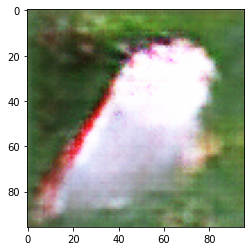

In [29]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
generated_image = 0.5 * generated_image + 0.5
plt.imshow(generated_image[0, :, :, :])

In [30]:
import numpy as np


**Define the directory where results folder will be made**

In [41]:
OUT_PATH_samples='/content/drive/My Drive/minor/final_aloa'

In [42]:
output_samples_path = os.path.join(OUT_PATH_samples,f"results")

**Make results folder in OUT_PATH_SAMPLES**

In [40]:
!mkdir '/content/drive/My Drive/minor/final_aloa/results'

**Below cell saves 500 synthetically generated images to the output_samples_path.**

In [43]:
x=500 # no of samples to be generated
for i in range(x):
  noise = tf.random.normal([1, SEED_SIZE])
  generated_image = generator(noise, training=False)
  generated_image = 0.5 * generated_image + 0.5
  generated_image=generated_image[0, :, :, :]
  filename = os.path.join(output_samples_path,f"aloa-{i}.png")
  generated_image=np.asarray(generated_image)
  im = Image.fromarray((generated_image * 255).astype(np.uint8))
  im.save(filename)
